In [1]:
'''Basic package'''
import os
# 告訴系統要第幾張卡被看到。 Ex. 硬體總共有8張顯卡，以下設定只讓系統看到第1張顯卡
# 若沒設定，則 Tensorflow 在運行時，預設會把所有卡都佔用
# 要看裝置內顯卡數量及目前狀態的話，請在終端機內輸入 "nvidia-smi"
# 若你的裝置只有一張顯卡可以使用，可以忽略此設定
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import queue
import cv2          #影像處理
import scipy.misc   #影像處理
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm #進度條
import matplotlib.pyplot as plt #繪圖
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# 自定義 library
# from generator import data_generators
# from callbacks import *


'''Tensorflow package'''
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as slimNet


'''Data augmentation package'''
from imgaug import augmenters as iaa
import imgaug as ia


In [2]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
from os import listdir
from os.path import isfile, isdir, join

# 指定要列出所有檔案的目錄
mypath = ["/home/jovyan/projectdata/emc01/train", "/home/jovyan/projectdata/emc01/test7_plate2_0328All", "/home/jovyan/at071-group30/face_images/casia/train_frames/"]
# mypath = ["/home/jovyan/projectdata/emc01/casia/train_frames"]
# mypath = ["/home/jovyan/at071-group30/face_images/casia/train_frames/"]
Class_list = []
Class_label_list = []
Path_list = []

for i in mypath:
    # 取得所有檔案與子目錄名稱
    print(i)
    files = listdir(i)
    # 以迴圈處理
    for f in files:
        # 產生檔案的絕對路徑
        fullpath = join(i, f)
        # 判斷 fullpath 是檔案還是目錄
        if isfile(fullpath):
            print("檔案：", f)
        elif isdir(fullpath):
            print("目錄：", f)
            if (f == 'fake_photo') | (f == 'fake_phonescreen') | (f == 'fake'):
                label = 0
            elif f == 'real':
                label = 1
            else:
                label = 999
            sub_files = listdir(fullpath)
            for ff in sub_files:
                if (ff[0:2] != '._') & (ff != '.ipynb_checkpoints'):
                    Class_list.append(f)
                    Class_label_list.append(label)
                    Path_list.append(fullpath + '/' + ff)

/home/jovyan/projectdata/emc01/train
檔案： ._real
檔案： ._.DS_Store
目錄： fake_photo
檔案： ._fake_photo
目錄： real
檔案： .DS_Store
目錄： fake_phonescreen
檔案： ._fake_phonescreen
/home/jovyan/projectdata/emc01/test7_plate2_0328All
檔案： ._real
檔案： ._.DS_Store
目錄： fake_photo
檔案： ._fake_photo
目錄： real
檔案： .DS_Store
目錄： fake_phonescreen
檔案： ._fake_phonescreen
/home/jovyan/at071-group30/face_images/casia/train_frames/
目錄： real
目錄： fake
目錄： .ipynb_checkpoints


In [3]:
len(Class_list)

25349

In [4]:
len(Path_list)

25349

In [5]:
img_df = pd.DataFrame({'Class':Class_list, 'Class_label':Class_label_list ,'Path':Path_list})
img_df.head()

,Class,Class_label,Path
0,fake_photo,0,/home/jovyan/projectdata/emc01/train/fake_phot...
1,fake_photo,0,/home/jovyan/projectdata/emc01/train/fake_phot...
2,fake_photo,0,/home/jovyan/projectdata/emc01/train/fake_phot...
3,fake_photo,0,/home/jovyan/projectdata/emc01/train/fake_phot...
4,fake_photo,0,/home/jovyan/projectdata/emc01/train/fake_phot...


In [6]:
img_df.groupby(['Class']).count()

,Class_label,Path
Class,,
fake,8561,8561
fake_phonescreen,5779,5779
fake_photo,5193,5193
real,5816,5816


In [7]:
img_df.groupby(['Class_label']).count()

,Class,Path
Class_label,,
0,19533,19533
1,5816,5816


/home/jovyan/projectdata/emc01/train/fake_photo/VID_19700517_075202_frame42.png


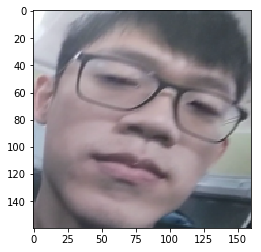

In [8]:
print(img_df.Path.iloc[10])
img = cv2.imread(img_df.Path.iloc[10])[:,:,::-1]
plt.imshow(img)

(160, 160, 3)

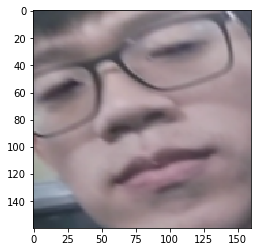

In [9]:
seq = iaa.Sequential([
        iaa.Fliplr(0.5),               # 左右翻轉
#         iaa.Flipud(0.5),               # 上下翻轉
        iaa.Affine(rotate=(-10, 10), # 旋轉
        scale=(0.6, 1.4),              # 縮放
mode = 'wrap',                 # 影像翻轉造成區塊缺值的補值方式
translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)})]) # 平移
img = seq.augment_image(img)

plt.imshow(img, cmap='gray')
img.shape

In [10]:
img_cla_y = pd.get_dummies(img_df['Class_label'], '').as_matrix()
print(img_cla_y[0])

[1 0]


In [11]:
img_size = 160
x_train_list, x_test_list, y_train, y_test = train_test_split(img_df, img_cla_y, test_size=0.05)  ## 將 input_x 和 input_y 各自區分成 training data 和 testing data

## record the dim of img ##
img = cv2.resize(img, (img_size,img_size))
# img = img.flatten()

print('input_data shape: training {training_shape} ; testing {testing_shape}'.format(
            training_shape=(len(x_train_list), img.shape), 
            testing_shape=(len(x_test_list), img.shape)))
print('y_true shape: training {training_shape} ; testing {testing_shape}'.format(
            training_shape=y_train.shape, 
            testing_shape=y_test.shape))

input_data shape: training (24081, (160, 160, 3)) ; testing (1268, (160, 160, 3))
y_true shape: training (24081, 2) ; testing (1268, 2)


In [12]:
x_train_list.groupby(['Class']).count()

,Class_label,Path
Class,,
fake,8155,8155
fake_phonescreen,5480,5480
fake_photo,4911,4911
real,5535,5535


In [13]:
x_test_list.groupby(['Class']).count()

,Class_label,Path
Class,,
fake,406,406
fake_phonescreen,299,299
fake_photo,282,282
real,281,281


## define image generator

In [14]:
from sklearn.utils import shuffle 

def img_train_batch_generator(x, y, bs, shape):
    x_train = np.array([]).reshape((0, shape*3))
    y_train = np.array([]).reshape((0, y.shape[1]))
    while True:
        new_ind = shuffle(range(len(x)))
        x = x.take(new_ind)
        y = np.take(y, new_ind, axis=0)
        for i in range(len(x)):
            dir_img = x.Path.iloc[i]
            img = cv2.imread(dir_img)[:,:,::-1]
            img = cv2.resize(img, (img_size,img_size))
            x_train = np.row_stack([x_train, img.flatten()])
            y_train = np.row_stack([y_train, y[i]])
            # Image_AUG
            seq = iaa.Sequential([
                    iaa.Fliplr(0.5),               # 左右翻轉
#                     iaa.Flipud(0.5),               # 上下翻轉
                    iaa.Affine(rotate=(-10, 10), # 旋轉
                    scale=(0.6, 1.4),              # 縮放
            mode = 'wrap',                 # 影像翻轉造成區塊缺值的補值方式
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)})]) # 平移
            img = seq.augment_image(img)
            x_train = np.row_stack([x_train, img.flatten()])
            y_train = np.row_stack([y_train, y[i]])
            
            if x_train.shape[0] == bs:
                x_batch = x_train.copy()
                x_batch /= 255.
                x_batch = x_batch.reshape(x_batch.shape[0], img_size, img_size, 3)
                y_batch = y_train.copy()
                x_train = np.array([]).reshape((0 ,shape*3))
                y_train = np.array([]).reshape((0 ,y.shape[1]))        
                yield x_batch, y_batch

def img_test_batch_generator(x, shape):
    x_test = np.array([]).reshape((0, shape*3))
#     for i in range(len(x)):
#         dir_img = x.Path.iloc[i]
#         img = cv2.imread(dir_img)[:,:,::-1]
#         img = cv2.resize(img, (img_size, img_size))
#         x_test = np.row_stack([x_test, img.flatten()])
        
    data_bar = tqdm(range(len(x)), desc="data", unit="data")
    gen_file = (cv2.resize(cv2.imread(x.Path.iloc[i])[:,:,::-1],(img_size,img_size),
                                   interpolation=cv2.INTER_CUBIC) for i in data_bar)
    x_test = np.stack(gen_file, axis=0)
    x_test = x_test / 255.
    x_test = x_test.reshape(x_test.shape[0], img_size, img_size, 3)
    return x_test

In [15]:
x_test = img_test_batch_generator(x_test_list, img.shape[0] * img.shape[1])

HBox(children=(IntProgress(value=0, description='data', max=1268), HTML(value='')))

In [16]:
x_test.shape

(1268, 160, 160, 3)

In [17]:
x_test[1].shape

(160, 160, 3)

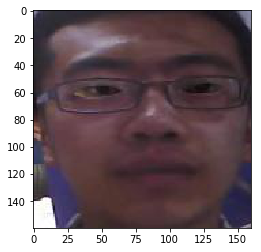

In [18]:
plt.imshow(x_test[1].reshape(img_size, img_size, 3))

## Create Graph

In [19]:
def classifier(x, num_class):
    x = tf.reduce_mean(x, [1,2]) # global average pooling
    x = tf.layers.dense(x, num_class)
    return x

In [20]:
'''graph

這部分就像一張計畫圖一樣，定義我們計算的流程
此部分沒辦法直接被執行，必須靠 session 才能實際執行運算

'''
tf.reset_default_graph() ## 重新 build graph 需要跑這行

num_class = 2
main_graph = tf.Graph()
sess = tf.Session(graph=main_graph)
with main_graph.as_default():
    #### optimizer ####
    lr = tf.placeholder(tf.float32, shape=[])
    optimizer = tf.train.AdamOptimizer(lr)
        
    #### placeholder ####
    input_data = tf.placeholder(dtype=tf.float32, shape=(None, img_size, img_size, 3), name='input_data')
    y_true = tf.placeholder(dtype=tf.float32, shape=(None, num_class), name='y_true')
    is_training = tf.placeholder(dtype=tf.bool, shape=[])
    
    #### model ####
    with slim.arg_scope(slimNet.resnet_utils.resnet_arg_scope(batch_norm_decay=0.99)):
        _, layers_dict = slimNet.resnet_v2.resnet_v2_50(input_data, global_pool=False, is_training=is_training)
        conv_output = layers_dict['resnet_v2_50/block4']
    
    with tf.variable_scope('CLASS_1'):
        y_pred = classifier(conv_output, num_class)
        pred_softmax = tf.nn.softmax(y_pred)
    
    #### loss ####
    loss = tf.losses.softmax_cross_entropy(y_true, y_pred)
    
    #### udpate ####
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) #使用內建的 batch normalization layer, 必須執行
    with tf.control_dependencies(update_ops):               #tf.GraphKeys.UPDATE_OPS 才會更新到 BN 層的 mean, variance
        update = optimizer.minimize(loss) 
        
    #### other ####
    var_list = tf.trainable_variables() # 與 tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) 相同    
    saver = tf.train.Saver() # 處理模型儲存、載入
    init = tf.global_variables_initializer()

In [21]:
sess.run(init)
#### load weights from pre-train model ####
saver_restore = tf.train.Saver([v for v in var_list if 'resnet_v2_50' in v.name])
saver_restore.restore(sess, '/home/jovyan/exam/resnet_v2_50/resnet_v2_50.ckpt')

INFO:tensorflow:Restoring parameters from /home/jovyan/exam/resnet_v2_50/resnet_v2_50.ckpt


In [22]:
var_list

[<tf.Variable 'resnet_v2_50/conv1/weights:0' shape=(7, 7, 3, 64) dtype=float32_ref>,
 <tf.Variable 'resnet_v2_50/conv1/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'resnet_v2_50/block1/unit_1/bottleneck_v2/preact/gamma:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'resnet_v2_50/block1/unit_1/bottleneck_v2/preact/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'resnet_v2_50/block1/unit_1/bottleneck_v2/shortcut/weights:0' shape=(1, 1, 64, 256) dtype=float32_ref>,
 <tf.Variable 'resnet_v2_50/block1/unit_1/bottleneck_v2/shortcut/biases:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'resnet_v2_50/block1/unit_1/bottleneck_v2/conv1/weights:0' shape=(1, 1, 64, 64) dtype=float32_ref>,
 <tf.Variable 'resnet_v2_50/block1/unit_1/bottleneck_v2/conv1/BatchNorm/gamma:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'resnet_v2_50/block1/unit_1/bottleneck_v2/conv1/BatchNorm/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'resnet_v2_50/block1/unit_1/bottleneck_v2/conv2/weigh

In [23]:
from tqdm import tqdm_notebook
import time
from sklearn.metrics import accuracy_score

test_loss_min = 99
epoch = 10
bs = 32
update_per_epoch = 100

tr_loss = list()
te_loss = list()
tr_acc = list()
te_acc = list()
print(img.shape[0] * img.shape[1])
train_gen = img_train_batch_generator(x_train_list, y_train, bs, img.shape[0] * img.shape[1])

print('start modelling!')

for i in range(epoch):
    
    #### calculate training loss & update variables ####
    training_loss = 0
    training_acc = 0
    bar = tqdm_notebook(range(update_per_epoch))
    for j in bar:
        
        x_batch, y_batch = next(train_gen)
        
        tr_pred, training_loss_batch, _ = sess.run([y_pred, loss, update], feed_dict={
            input_data:x_batch,
            y_true:y_batch,
            is_training: True, 
            lr:1.7e-4
        })
        
        training_loss += training_loss_batch
        
        training_acc_batch = accuracy_score(np.argmax(y_batch, axis=1), np.argmax(tr_pred, axis=1))
        training_acc += training_acc_batch
        
        if j % 5 == 0:
            bar.set_description('loss: %.4g' % training_loss_batch)

    training_loss /= update_per_epoch
    training_acc /= update_per_epoch
    
    #### calculate testing data loss ####
    te_pred, testing_loss = sess.run([y_pred, loss], feed_dict={
        input_data:x_test,
        y_true:y_test,
        is_training: False
    })
    
    testing_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(te_pred, axis=1))
    
    tr_loss.append(training_loss)
    te_loss.append(testing_loss)
    tr_acc.append(training_acc)
    te_acc.append(testing_acc)
    
    print('epoch {epochs}: training loss {training_loss} ; testing loss {testing_loss}, testing acc {testing_acc}'.format(
            epochs=(i+1), 
            training_loss=training_loss,
            testing_loss=testing_loss,
            testing_acc=testing_acc))
    if test_loss_min > testing_loss:
        test_loss_min = testing_loss
        save_path = saver.save(sess, "/home/jovyan/Spoof_face_detect/model_checkpoint/model_Resnet.ckpt")
        print('Save Model!!')
        

25600
start modelling!


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 1: training loss 0.2732629434391856 ; testing loss 1.3918185234069824, testing acc 0.7783911671924291
Save Model!!


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 2: training loss 0.17277078448794783 ; testing loss 1.7618376016616821, testing acc 0.7783911671924291


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 3: training loss 0.11507456277497113 ; testing loss 2.0182952880859375, testing acc 0.7783911671924291


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 4: training loss 0.08876749360759277 ; testing loss 0.4668683409690857, testing acc 0.8777602523659306
Save Model!!


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 5: training loss 0.11470905096153729 ; testing loss 0.046187009662389755, testing acc 0.9850157728706624
Save Model!!


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 6: training loss 0.10866552102495916 ; testing loss 0.09132204204797745, testing acc 0.9700315457413249


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 7: training loss 0.08926210912526585 ; testing loss 0.09004966914653778, testing acc 0.9700315457413249


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 8: training loss 0.06879256607033313 ; testing loss 0.011688319966197014, testing acc 0.9960567823343849
Save Model!!


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 9: training loss 0.05575720595079474 ; testing loss 0.025891166180372238, testing acc 0.9921135646687698


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 10: training loss 0.07489172814806806 ; testing loss 0.01997029222548008, testing acc 0.9929022082018928


## Old Model

## Restore Model

In [24]:
# saver = tf.train.Saver()
saver.restore(sess, "/home/jovyan/Spoof_face_detect/model_checkpoint/model_Resnet.ckpt")

INFO:tensorflow:Restoring parameters from /home/jovyan/Spoof_face_detect/model_checkpoint/model_Resnet.ckpt


Text(0.5,1,'Accuracy')

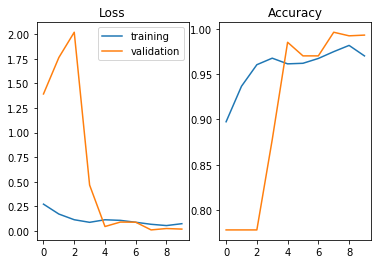

In [25]:
plt.figure(1)
plt.subplot(121)
plt.plot(range(len(tr_loss)), tr_loss, label='training')
plt.plot(range(len(te_loss)), te_loss, label='validation')
plt.title('Loss')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(range(len(tr_acc)), tr_acc, label='training')
plt.plot(range(len(te_acc)), te_acc, label='validation')
plt.title('Accuracy')

## Test Data

In [26]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
from os import listdir
from os.path import isfile, isdir, join

# 指定要列出所有檔案的目錄
# mypath = "/home/jovyan/projectdata/emc01/test7_plate2_0328All"
mypath = ["/home/jovyan/projectdata/emc01/test", "/home/jovyan/projectdata/emc01/test7_plate2_0328All", "/home/jovyan/at071-group30/face_images/casia/test_frames/"]
# mypath = "/home/jovyan/at071-group30/"
# mypath = "/home/jovyan/projectdata/emc01/casia/test_frames"
# mypath = "/home/jovyan/at071-group30/face_images/casia/test_frames/"

# # 取得所有檔案與子目錄名稱
# files = listdir(mypath)

Class_list = []
Class_label_list = []
Path_list = []
for i in mypath:
    # 取得所有檔案與子目錄名稱
    print(i)
    files = listdir(i)
    # 以迴圈處理
    for f in files:
        # 產生檔案的絕對路徑
        fullpath = join(i, f)
        # 判斷 fullpath 是檔案還是目錄
        if isfile(fullpath):
            print("檔案：", f)
        elif isdir(fullpath):
            print("目錄：", f)
            if (f == 'fake_photo') | (f == 'fake_phonescreen') | (f == 'fake'):
                label = 0
            elif f == 'real':
                label = 1
            else:
                label = 999
            sub_files = listdir(fullpath)
            for ff in sub_files:
                if (ff[0:2] != '._') & (ff != '.ipynb_checkpoints'):
                    Class_list.append(f)
                    Class_label_list.append(label)
                    Path_list.append(fullpath + '/' + ff)

/home/jovyan/projectdata/emc01/test
檔案： ._real
檔案： ._.DS_Store
目錄： fake_photo
檔案： ._fake_photo
目錄： real
檔案： .DS_Store
目錄： fake_phonescreen
檔案： ._fake_phonescreen
/home/jovyan/projectdata/emc01/test7_plate2_0328All
檔案： ._real
檔案： ._.DS_Store
目錄： fake_photo
檔案： ._fake_photo
目錄： real
檔案： .DS_Store
目錄： fake_phonescreen
檔案： ._fake_phonescreen
/home/jovyan/at071-group30/face_images/casia/test_frames/
目錄： real
目錄： fake
目錄： .ipynb_checkpoints


In [27]:
len(Class_list)

9706

In [28]:
len(Class_label_list)

9706

In [29]:
len(Path_list)

9706

In [30]:
testset_df =pd.DataFrame({'Class':Class_list, 'Class_label':Class_label_list ,'Path':Path_list})
# testset_df = testset_df[testset_df.Class == 'face_images']
testset_df

,Class,Class_label,Path
0,fake_photo,0,/home/jovyan/projectdata/emc01/test/fake_photo...
1,fake_photo,0,/home/jovyan/projectdata/emc01/test/fake_photo...
2,fake_photo,0,/home/jovyan/projectdata/emc01/test/fake_photo...
3,fake_photo,0,/home/jovyan/projectdata/emc01/test/fake_photo...
4,fake_photo,0,/home/jovyan/projectdata/emc01/test/fake_photo...
5,fake_photo,0,/home/jovyan/projectdata/emc01/test/fake_photo...
6,fake_photo,0,/home/jovyan/projectdata/emc01/test/fake_photo...
7,fake_photo,0,/home/jovyan/projectdata/emc01/test/fake_photo...
8,fake_photo,0,/home/jovyan/projectdata/emc01/test/fake_photo...
9,fake_photo,0,/home/jovyan/projectdata/emc01/test/fake_photo...


In [31]:
testset_df.groupby(['Class_label']).count()

,Class,Path
Class_label,,
0,7397,7397
1,2309,2309


In [32]:
testset = img_test_batch_generator(testset_df, img.shape[0] * img.shape[1])

HBox(children=(IntProgress(value=0, description='data', max=9706), HTML(value='')))

In [33]:
testset.shape

(9706, 160, 160, 3)

In [34]:
test_pred = sess.run([y_pred], feed_dict={input_data:testset[:1000], is_training: False})
test_pred_label = np.argmax(test_pred[0], axis=1)
test_pred = sess.run([y_pred], feed_dict={input_data:testset[1000:2000], is_training: False})
test_pred_label = np.append(test_pred_label, np.argmax(test_pred[0], axis=1))
test_pred = sess.run([y_pred], feed_dict={input_data:testset[2000:3000], is_training: False})
test_pred_label = np.append(test_pred_label, np.argmax(test_pred[0], axis=1))
test_pred = sess.run([y_pred], feed_dict={input_data:testset[3000:4000], is_training: False})
test_pred_label = np.append(test_pred_label, np.argmax(test_pred[0], axis=1))
test_pred = sess.run([y_pred], feed_dict={input_data:testset[4000:5000], is_training: False})
test_pred_label = np.append(test_pred_label, np.argmax(test_pred[0], axis=1))
test_pred = sess.run([y_pred], feed_dict={input_data:testset[5000:6000], is_training: False})
test_pred_label = np.append(test_pred_label, np.argmax(test_pred[0], axis=1))
test_pred = sess.run([y_pred], feed_dict={input_data:testset[6000:7000], is_training: False})
test_pred_label = np.append(test_pred_label, np.argmax(test_pred[0], axis=1))
test_pred = sess.run([y_pred], feed_dict={input_data:testset[7000:8000], is_training: False})
test_pred_label = np.append(test_pred_label, np.argmax(test_pred[0], axis=1))
test_pred = sess.run([y_pred], feed_dict={input_data:testset[8000:9000], is_training: False})
test_pred_label = np.append(test_pred_label, np.argmax(test_pred[0], axis=1))
test_pred = sess.run([y_pred], feed_dict={input_data:testset[9000:], is_training: False})
test_pred_label = np.append(test_pred_label, np.argmax(test_pred[0], axis=1))

print(test_pred_label)
test_acc = accuracy_score(testset_df.Class_label.values, test_pred_label)
print(test_acc)

[0 0 0 ..., 0 0 0]
0.995260663507


In [35]:
# test_pred = sess.run([y_pred], feed_dict={input_data:testset, is_training: False})
# test_pred_label = np.argmax(test_pred[0], axis=1)
# test_pred_label

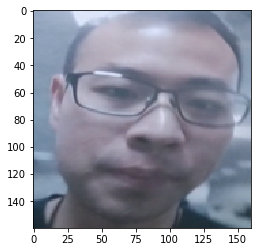

In [36]:
plt.imshow(testset[107])